<a href="https://colab.research.google.com/github/puja431996/Notebook/blob/master/Three_Class_MobileNetV2(3_Class).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

---



In [0]:
# import keras
import tensorflow as tf
from zipfile import ZipFile
from matplotlib import pyplot as plt
import cv2
import os
import seaborn as sn
import numpy as np
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import keras
import keras.backend as K
from keras.models import Sequential
from tensorflow.keras.models import load_model
from keras import layers 
#from keras.applications import VGG16 
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import MobileNet
from keras.optimizers import SGD,Adam,RMSprop
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

###Mount Drive

---



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cd drive && cd 'My Drive' && cd COVID_19 && cd covid19-detection-xray-dataset_3_Class && ls

TrainData  ValData


#Image Preprocessing

---



###ImageDataGenerator

---



In [0]:
img_height = 224
img_width = 224
batch_size = 32

train_data_dir = "/content/drive/My Drive/COVID_19/covid19-detection-xray-dataset_3_Class/"
train_datagen = ImageDataGenerator( rescale = 1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir+"TrainData/",
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        train_data_dir+"ValData/",
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical',
        shuffle = False)

Found 2143 images belonging to 3 classes.
Found 1263 images belonging to 3 classes.


#Tansfer Learning

---



##Built Model

---



###Load Model

---



In [0]:
loaded_model = load_model("/content/drive/My Drive/saved_models/mobilenetv2_finetuned.h5")

In [0]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
loaded_model.layers[-2].output

<tf.Tensor 'global_average_pooling2d_2/Identity:0' shape=(None, 1280) dtype=float32>

###Remove last layer

---



In [0]:
from tensorflow.keras.models import Model
loaded_model.layers.pop()
loaded_model.layers.pop()
top_model = Model(loaded_model.input,loaded_model.layers[-2].output)

In [0]:
top_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224_input ( [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
Total params: 2,257,984
Trainable params: 1,862,592
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
top_model.trainable = False

In [0]:
top_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224_input ( [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
hidden_layer = tf.keras.layers.Dense(64,activation="relu")
dropout_layer = tf.keras.layers.Dropout(0.5) 
#hidden_layer1 = tf.keras.layers.Dense(32,activation="relu")
#dropout_layer1 = tf.keras.layers.Dropout(0.5)   #0.5
prediction_layer = tf.keras.layers.Dense(3,activation="softmax")

###Transfer learning using model trained on Mendleye data with binary classification

---



In [0]:
model = tf.keras.Sequential([
  top_model,
  hidden_layer,
  dropout_layer,
  prediction_layer
])

###Final model summary

---



In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 2,340,163
Trainable params: 82,179
Non-trainable params: 2,257,984
_________________________________________________________________


###Model Compiling

---



In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=0.0),metrics=['accuracy'])        #0.0001

###Use EarlyStop and Csv Logger

---



In [0]:
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping
csv_logger = CSVLogger('Multi_Class_MobileNetV2_3_class_FineTune.csv', append=False, separator=';')
#ES = EarlyStopping(monitor='val_accuracy', patience=3)

###Fit model

---



In [0]:
history = model.fit(train_generator,steps_per_epoch=67,epochs = 20,validation_data=validation_generator,validation_steps= 1263,verbose=1,callbacks=[csv_logger])

Epoch 1/20
67/67 [==============================] - 1700s 25s/step - loss: 0.4736 - accuracy: 0.7984 - val_loss: 0.3911 - val_accuracy: 0.8306
Epoch 2/20
67/67 [==============================] - 48s 717ms/step - loss: 0.2938 - accuracy: 0.8819 - val_loss: 0.3261 - val_accuracy: 0.8781
Epoch 3/20
67/67 [==============================] - 47s 708ms/step - loss: 0.2122 - accuracy: 0.9193 - val_loss: 0.2887 - val_accuracy: 0.8923
Epoch 4/20
67/67 [==============================] - 49s 724ms/step - loss: 0.1925 - accuracy: 0.9305 - val_loss: 0.3450 - val_accuracy: 0.8717
Epoch 5/20
67/67 [==============================] - 49s 726ms/step - loss: 0.1462 - accuracy: 0.9477 - val_loss: 0.3452 - val_accuracy: 0.8844
Epoch 6/20
67/67 [==============================] - 49s 732ms/step - loss: 0.1270 - accuracy: 0.9585 - val_loss: 0.3237 - val_accuracy: 0.8844
Epoch 7/20
67/67 [==============================] - 49s 731ms/step - loss: 0.1157 - accuracy: 0.9566 - val_loss: 0.4132 - val_accuracy: 0.8630

##Outputs

---



###Accuracy and Loss Plot

---



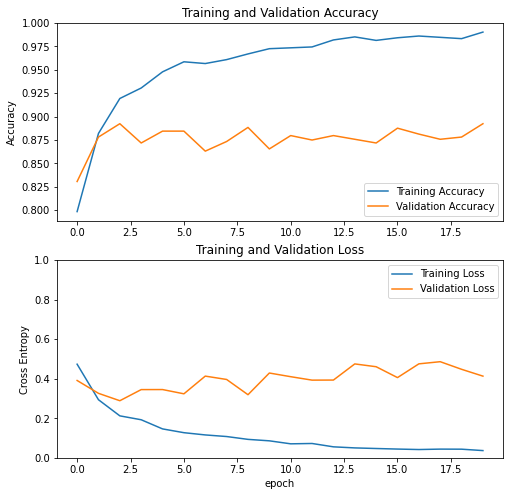

In [0]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
model.save("/content/drive/My Drive/saved_models/mobilenetv2_3classes_base.h5")

##FINE TUNING

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 2,340,163
Trainable params: 82,179
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
top_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224_input ( [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
top_model.trainable = True

In [0]:
print("Number of layers in the base model: ", len(top_model.layers))
fine_tune_at = 100

for layer in top_model.layers[1].layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  3


In [0]:
top_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224_input ( [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
Total params: 2,257,984
Trainable params: 1,862,592
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 2,340,163
Trainable params: 1,944,771
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [0]:
csv_logger = CSVLogger('Multi_Class_MobileNetV2_3_class_FineTune.csv', append=True, separator=';')

In [0]:
fine_tune_epochs = 20
initial_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_generator,steps_per_epoch=67,epochs = total_epochs,initial_epoch =  initial_epochs,validation_data=validation_generator,callbacks=[csv_logger],validation_steps=1263)

Epoch 21/40
67/67 [==============================] - 50s 744ms/step - loss: 0.8053 - accuracy: 0.7979 - val_loss: 0.3864 - val_accuracy: 0.8860
Epoch 22/40
67/67 [==============================] - 48s 723ms/step - loss: 0.2937 - accuracy: 0.9034 - val_loss: 0.5352 - val_accuracy: 0.8242
Epoch 23/40
67/67 [==============================] - 48s 714ms/step - loss: 0.1629 - accuracy: 0.9407 - val_loss: 0.5340 - val_accuracy: 0.8266
Epoch 24/40
67/67 [==============================] - 48s 714ms/step - loss: 0.1361 - accuracy: 0.9529 - val_loss: 0.5285 - val_accuracy: 0.8226
Epoch 25/40
67/67 [==============================] - 48s 715ms/step - loss: 0.1079 - accuracy: 0.9622 - val_loss: 0.5545 - val_accuracy: 0.8187
Epoch 26/40
67/67 [==============================] - 48s 713ms/step - loss: 0.0935 - accuracy: 0.9692 - val_loss: 0.5635 - val_accuracy: 0.8219
Epoch 27/40
67/67 [==============================] - 48s 712ms/step - loss: 0.0603 - accuracy: 0.9809 - val_loss: 0.5272 - val_accuracy:

In [0]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']

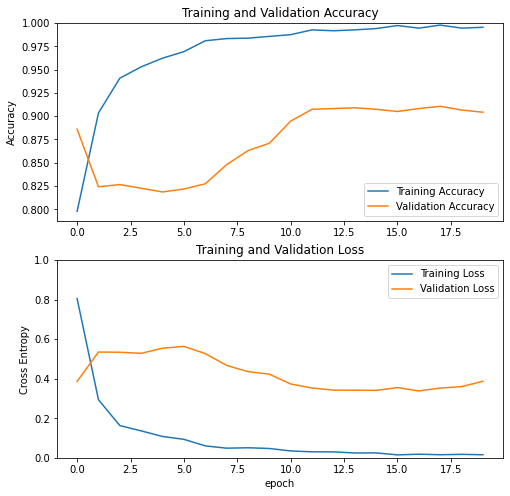

In [0]:
import matplotlib.pyplot as plt
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

###Confusion Matrix

---



In [0]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
validation_generator.reset()
Y_preds=model.predict_generator(validation_generator,1263)
y_pred = np.argmax(Y_preds, axis=1)
Matrix = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(Matrix)
print('Classification Report')
target_names = ['COVID-19', 'Normal', 'Pneumonia']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[241   6  31]
 [  0 441  15]
 [ 10  59 460]]
Classification Report
              precision    recall  f1-score   support

    COVID-19       0.96      0.87      0.91       278
      Normal       0.87      0.97      0.92       456
   Pneumonia       0.91      0.87      0.89       529

    accuracy                           0.90      1263
   macro avg       0.91      0.90      0.91      1263
weighted avg       0.91      0.90      0.90      1263



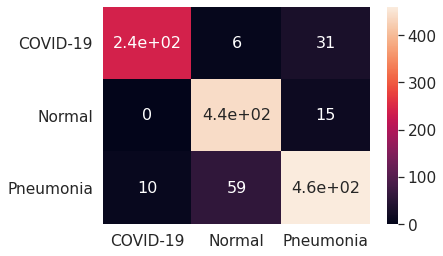

In [0]:
df_cm = pd.DataFrame(Matrix, target_names, target_names)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [0]:
model.save("/content/drive/My Drive/saved_models/mobilenetv2_3classes_finetune.h5")

###Test Images

---



In [0]:
score = model.evaluate_generator(validation_generator,steps=1263)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [0]:
score[1]

0.9041963815689087

In [0]:
from keras.preprocessing import image
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224,224))
  x = image.img_to_array(img)
  
  x = np.expand_dims(x, axis=0)/255.0

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  if np.argmax(classes[0]) == 0:
    print(fn + 'is covid-19')
  elif np.argmax(classes[0]) == 1:
    print(fn + 'is Normal')
  else:
    print(fn + 'is Pneumonia')

Saving person1_bacteria_1.jpeg to person1_bacteria_1.jpeg
Saving person1_bacteria_2.jpeg to person1_bacteria_2.jpeg
Saving person2_bacteria_3.jpeg to person2_bacteria_3.jpeg
Saving person2_bacteria_4.jpeg to person2_bacteria_4.jpeg
Saving person3_bacteria_10.jpeg to person3_bacteria_10.jpeg
Saving person3_bacteria_11.jpeg to person3_bacteria_11.jpeg
Saving person3_bacteria_12.jpeg to person3_bacteria_12.jpeg
Saving person3_bacteria_13.jpeg to person3_bacteria_13.jpeg
Saving person4_bacteria_14.jpeg to person4_bacteria_14.jpeg
Saving person5_bacteria_15.jpeg to person5_bacteria_15.jpeg
Saving person5_bacteria_16.jpeg to person5_bacteria_16.jpeg
Saving person5_bacteria_17.jpeg to person5_bacteria_17.jpeg
person1_bacteria_1.jpegis Pneumonia
person1_bacteria_2.jpegis Pneumonia
person2_bacteria_3.jpegis Pneumonia
person2_bacteria_4.jpegis Pneumonia
person3_bacteria_10.jpegis Pneumonia
person3_bacteria_11.jpegis Pneumonia
person3_bacteria_12.jpegis covid-19
person3_bacteria_13.jpegis Normal
